# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as Model #Model module builds basic parts of the advection diffusion PDE problem, combines other classes into full model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as MFModel

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointAdvectionDiffusionModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindSimple #Wind model

#Plotting tools
import matplotlib.pyplot as plt

def plot_timeslices(arr,fulltitle,times=[0,28,49],clim_a=None,clim_b=None):
    if clim_a is None: clim_a=np.floor(np.min((np.min(arr[times]))))
    if clim_b is None: clim_b=np.ceil(np.max((np.max(arr[times]))))
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure()

    ploti = 0
    for title, data in zip([fulltitle],[arr]):
        for t in times:
            ploti+=1
            plt.subplot(1,3,ploti)
            im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
            time = t*dt
            plt.xlabel("t=%d" % time,fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.clim(clim_a,clim_b)


            tick_font_size = 16
            if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
            #if ploti % 3 == 3:
            #    plt.colorbar(im1,fraction=0.046, pad=0.04)

    fig.tight_layout(rect=[0.1, 0.2, 1, 1])

    cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
    cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
    #cbar = plt.colorbar(im3,fraction=0.046)
    tick_font_size = 16
    cbar.ax.tick_params(labelsize = tick_font_size)
    plt.show()
    

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which includes the start and end times of the observation period and the x and y locations that the observation was taken at. Consider an array of four sensors in a grid that each take two time averaged readings. 

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,5) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.01 # upper time

sensors = FixedSensorModel(X,0.01) # establish sensor model arguments are sensor locations and spatial averaging

/tmp/ipykernel_13058/2046575662.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xk" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X[:,2],X[:,3],'xk',markersize=15,color='b')


Text(0.5, 1.0, 'Sensor Locations')

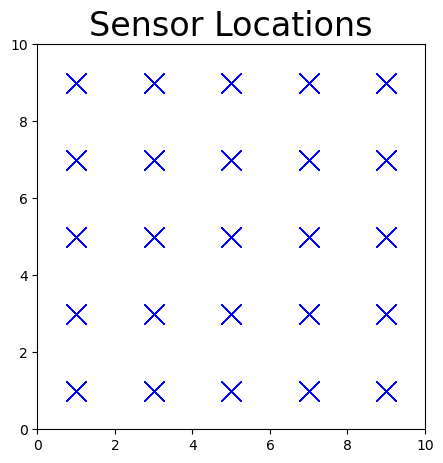

In [3]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(X[:,2],X[:,3],'xk',markersize=15,color='b')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Sensor Locations",fontsize=24)

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [4]:
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging (second argument)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a 10x10x10 grid in space and time.

### Establish forward model parameters

In [5]:
k_0 = 0.01 #Diffusion coefficient
noiseSD = 0.05 #Observation noise
N_feat=300 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
kForward = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [300,50,50] # grid size for time, x and y
#u=[]
#u.append(np.ones(res)*0.01) #x direction wind
#u.append(np.ones(res)*0.01) # y direction wind
#windmodel=WindFixU(u) # establish fixed wind model
windmodel=WindSimple(0.01,0.03)

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [6]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #initiate PDE model to build concentration

delta, Ns = m.getGridStepSize() # useful numbers!
dt = delta[0]
#z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
#sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
sourceGT = np.zeros(m.resolution)
sourceGT[:,7:15,7:15] = 10.0 # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

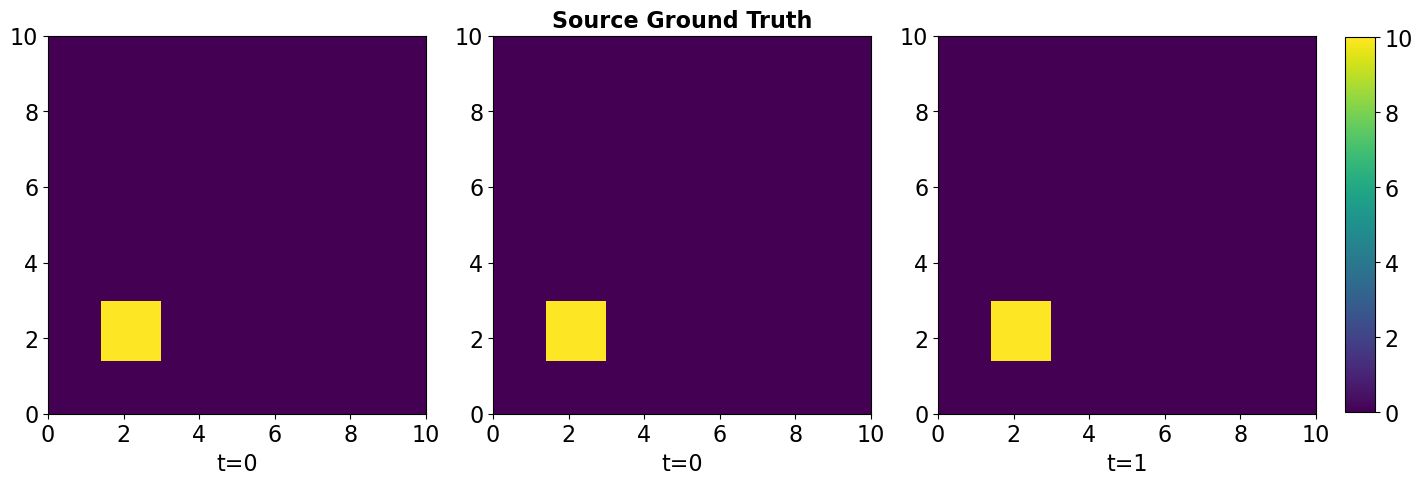

In [7]:
plot_timeslices(sourceGT,"Source Ground Truth")


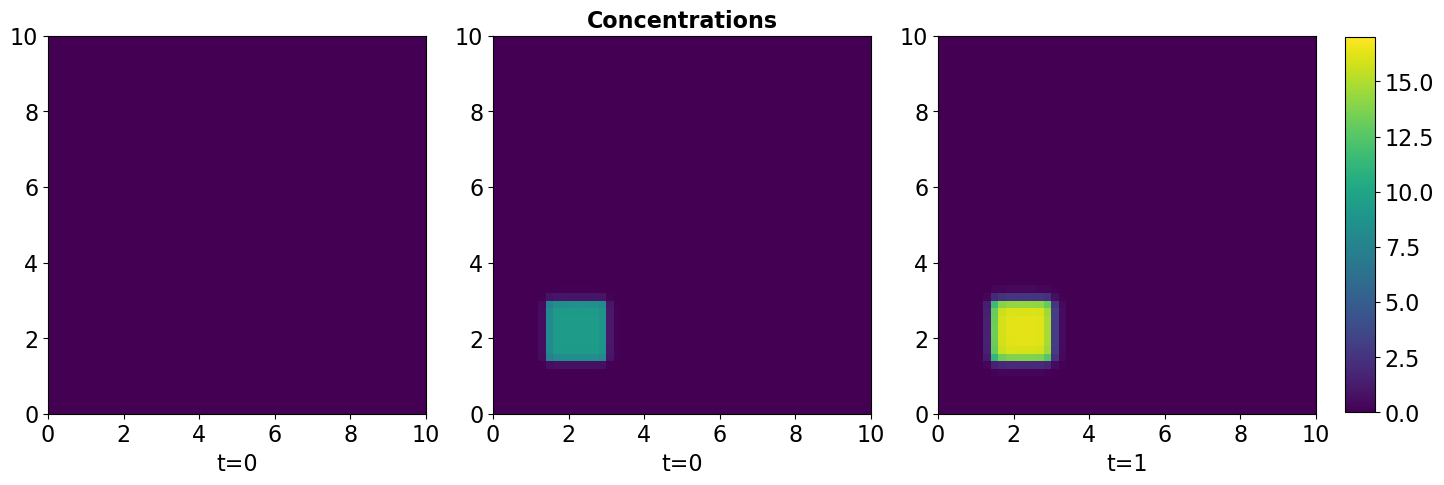

In [8]:
plot_timeslices(concTrain,"Concentrations")


# Inverse Problem Example

In [9]:
N_feat = 1000 #Number of features used to infer the source
kInverse = EQ(2, 2.0) # Initiate kernel for inverse problem
adjointmInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source

KeyboardInterrupt: 

In [ ]:
plot_timeslices(sourceInfer[:,:-1,:-1],"Inferred Source",clim_a=-4,clim_b=5)

In [ ]:
plot_timeslices(concInfer,"Inferred Concentration")

# Using the MeshFree Model

In [10]:
class SensorSentinel5Model():
    def __init__(self):    
        pass

    def genParticles(self,Nparticles):
        """
        Nparticles = number of particles per observation
        """
        Nobservations = 10
        #Implement this!!!
        return np.random.randn(Nparticles,Nobservations,3)
new_sensors = SensorSentinel5Model()

from advectionGP.wind import Wind
class windFromMERRA2(Wind):
    def __init__(self):
        pass
    def getwind(self,coords):
        print(coords.shape)
        print(coords)
        #Implement this!!!
        return coords[:,:,:2]

new_windmodel = windFromMERRA2()

kInverse = EQ(2, 2.0) # Initiate kernel for inverse problem
lowres = res #[300,10,10]
N_feat = 100
mMFInfer = MFModel(resolution=lowres,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=new_sensors,windmodel=new_windmodel,k_0=k_0) #Initiate new model for inference
mMFInfer.computeModelRegressors(Nparticles=50) # Compute regressor matrix

Initialising particles...
Diffusing particles...
(50, 10, 3)
[[[ 0.58808208 -0.21857321  2.092244  ]
  [-0.20373116 -0.63257971  1.77162742]
  [ 2.08978981  0.68470493  2.04944711]
  ...
  [ 1.00229354 -2.01875767 -0.09664259]
  [-0.47586305 -1.35544913  0.00726208]
  [-0.6247971  -0.33231996  1.75760091]]

 [[ 0.35149375 -1.24770853 -1.87720914]
  [ 1.14710491  0.81404213 -0.18676549]
  [-1.77863716  0.55922981 -0.4867419 ]
  ...
  [ 0.31287784  1.1047249   0.08969233]
  [ 1.40855921 -0.43762469 -1.15624883]
  [ 1.51254997 -0.4850806  -0.03508436]]

 [[-0.05495689  0.15092695 -0.17164478]
  [ 1.47134171 -0.10392981 -0.5172003 ]
  [ 0.99967481  0.92607828  0.83808319]
  ...
  [-0.90501288  0.08595373  0.5918093 ]
  [ 0.16364714 -1.54185324  1.26266094]
  [ 0.29781316  0.21832285  0.08181566]]

 ...

 [[ 1.15514694  2.34908566  0.13553715]
  [-0.4136147  -0.78966983  2.47073181]
  [ 0.49803637  0.14966712 -0.9673843 ]
  ...
  [ 1.14812754 -0.6288761   1.02371793]
  [-0.61925362  0.49850

array([[-7.44631055e-02,  0.00000000e+00, -1.78272622e-01,
        -3.96661378e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.17015870e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 1.63508362e-02,  0.00000000e+00, -4.60337175e-02,
         1.73724916e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.96948361e-03,  0.00000000e+00,
         0.00000000e+00],
       [ 2.30013452e-02,  0.00000000e+00,  1.02588097e-02,
         1.94058989e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.11072242e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 1.69445512e-02,  0.00000000e+00,  3.73180773e-02,
         2.72401510e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.33313194e-02,  0.00000000e+00,
         0.00000000e+00],
       [-2.08678652e-04,  0.00000000e+00,  4.93738985e-02,
        -7.92145817e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.77020323e-02,  0.00000000e+00,
         0.

Initialising particles...
Diffusing particles...
(50, 125, 3)
[[[1.00857566 1.         1.        ]
  [1.00918032 1.         3.        ]
  [1.00335025 1.         5.        ]
  ...
  [9.00207456 9.         5.        ]
  [9.00845292 9.         7.        ]
  [9.00067254 9.         9.        ]]

 [[1.00343663 1.         1.        ]
  [1.00027559 1.         3.        ]
  [1.0051177  1.         5.        ]
  ...
  [9.0065104  9.         5.        ]
  [9.00424995 9.         7.        ]
  [9.00541929 9.         9.        ]]

 [[1.00708306 1.         1.        ]
  [1.00017197 1.         3.        ]
  [1.00868383 1.         5.        ]
  ...
  [9.00428555 9.         5.        ]
  [9.00657305 9.         7.        ]
  [9.00528598 9.         9.        ]]

 ...

 [[1.00774657 1.         1.        ]
  [1.00182191 1.         3.        ]
  [1.00888437 1.         5.        ]
  ...
  [9.00994462 9.         5.        ]
  [9.00891971 9.         7.        ]
  [9.00516214 9.         9.        ]]

 [[1.0015834

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [10]:
lowres = res #[300,10,10]
N_feat = 1000
mMFInfer = MFModel(resolution=lowres,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mMFInfer.computeModelRegressors(Nparticles=50) # Compute regressor matrix
meanZ, covZ = mMFInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mMFInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution


Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
Coords NONE!
Computing over coords...
(3, 300, 50, 50)
Computing Source from Phi...


In [11]:
#Compute source grid
coords = mMFInfer.coords.transpose([1,2,3,0])
#sources = np.array([mMFInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sources = mMFInfer.computeSourceFromPhiInterpolated(meanZ,coords=coords[:,:,:,:])
sourcesmean = sources[0,:,:] #np.mean(sources,0)
#sourcesvar = np.var(sources,0)




cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 300, 50, 50)
Computing Source from Phi...


In [ ]:
plot_timeslices(sources[:,:-1,:-1],"Inferred Source",clim_a=-4,clim_b=5)#,clim_a=-20,clim_b=15)

### Trying different numbers of particles

In [ ]:
plt.figure(figsize=[15,7])
for i,Nparticles in enumerate([1,2,4,8,16]):
    mMFInfer.computeModelRegressors(Nparticles=Nparticles) # Compute regressor matrix
    #print(mMFInfer.X[1,2])
    meanZ, covZ = mMFInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    sourceInfer = mMFInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
    sources = mMFInfer.computeSourceFromPhiInterpolated(meanZ,coords=coords[28:29,:,:,:])
    plt.subplot(2,3,i+1)
    plt.title('%d particles' % Nparticles)
    plt.imshow(sources[0,:-1,:-1], extent=[0,10,0,10],origin='lower')
    plt.clim([-4,5])
    plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(sourceInfer[28,:-1,:-1], extent=[0,10,0,10],origin='lower')
plt.clim([-4,5])
plt.colorbar()
plt.title('Mesh-based')
plt.savefig('mesh_meshfree_comparison.pdf')

In [ ]:
#plt.imshow(np.sqrt(sourcesvar),origin='lower')
#plt.colorbar()

In [ ]:
plt.figure(figsize=[4,4])
plt.imshow(sourcesmean,origin='lower')
plt.colorbar()
#plt.clim([0,4])

In [ ]:
#compute concentration grid
#concmean,concvar,concentrations = mMFInfer.computeConcentration(Nparticles=300,
#                                                                   Zs=Zs,interpolateSource=True,
#                                                                   coords=coords)
concmean,concvar,concentrations = mMFInfer.computeConcentration(Nparticles=300,
                                                                   Zs=meanZ[None,:],interpolateSource=True,
                                                                   coords=coords[::10,:,:,:])

In [ ]:
plt.imshow(concmean[-1,:,:],origin='lower')
plt.colorbar()
#plt.clim([0,4])

In [ ]:
plot_timeslices(sourceInfer,"Inferred Source")

In [ ]:
plot_timeslices(concmean,"Inferred Concentration",times=[1,3,6])

# Using the Mesh Model

In [ ]:
lowres = [300,10,10]
N_feat = 3000
mMFInfer = Model(resolution=lowres,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mMFInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mMFInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mMFInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
